In [74]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, sosfilt
from sklearn.impute import SimpleImputer

In [75]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Load training data
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
df = pd.read_csv(PATH + 'train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df


Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          106800 non-null  i

In [77]:
df.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,1.538873,2.818845,3.131889,2.136799,2.228492,3.621180
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,19.000000,18.000000,16.000000,15.000000,15.000000,25.000000


In [78]:

# Aggregate EEG data
train = df.groupby('eeg_id')[['spectrogram_id', 'spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
train.columns = ['spectrogram_id', 'min']

tmp = df.groupby('eeg_id')[['spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds': 'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

# Normalize target labels
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()

# Split dataset
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
train_data.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
9565,2380136004,1373665987,424.0,428.0,63252,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,Seizure
9652,2402531371,1235837428,84.0,88.0,13521,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,Other
11899,2968861754,940600546,0.0,12.0,5512,0.0,0.000000,0.071429,0.071429,0.428571,0.428571,GRDA
9479,2355114818,506283361,0.0,14.0,34298,0.0,0.333333,0.000000,0.333333,0.000000,0.333333,LPD
11955,2981162415,1505926989,1148.0,1180.0,35627,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,LPD


In [79]:
val_data.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
5761,1432453780,1327880777,0.0,24.0,59230,0.0,0.0,1.0,0.0,0.0,0.0,GPD
5290,1319305051,1908433744,5329.0,5329.0,17408,0.0,0.0,1.0,0.0,0.0,0.0,GPD
14548,3645342149,1725735958,0.0,0.0,32042,0.0,0.0,0.0,0.0,0.0,1.0,Other
6914,1706995682,172731638,4182.0,4182.0,35225,0.0,0.0,0.0,0.0,0.0,1.0,Other
1346,346529642,437642675,0.0,0.0,41602,0.0,0.0,0.5,0.0,0.0,0.5,GPD


In [80]:
# Define EEG Dataset class
# Define EEG Dataset class
class EEGDataset(Dataset):
    def __init__(self, data, eeg_path):
        self.csv = data.reset_index(drop=True)  # Reset index here
        self.eeg_path = eeg_path
        self.sos = self.butter_bandpass_filter_init()
        self.FEATS = ['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']

    def butter_bandpass_filter_init(self):
        lowcut = 0.5
        highcut = 40.0
        fs = 200.0
        order = 5
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

    def butter_bandpass_filter(self, data):
        return sosfilt(self.sos, data)

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        # Use iloc to access by position
        eeg_id = self.csv.iloc[idx]['eeg_id']  
        eeg_file_path = f"{EEG_PATH}{eeg_id}.parquet"
        eeg_data = pd.read_parquet(eeg_file_path)[self.FEATS].values

        if np.isnan(eeg_data).any():
            imputer = SimpleImputer(strategy='mean')
            eeg_data = imputer.fit_transform(eeg_data)

        eeg_data = self.butter_bandpass_filter(eeg_data)
        eeg_data = torch.tensor(eeg_data, dtype=torch.float32)

        mid_index = eeg_data.shape[0] // 2
        start_index = mid_index - 5000
        end_index = mid_index + 5000
        eeg_data = eeg_data[start_index:end_index]
        eeg_data = torch.transpose(eeg_data, 0, 1)

        labels = torch.tensor(self.csv.iloc[idx][TARGETS].values.astype(np.float32), dtype=torch.float32)  # Use iloc here
        return eeg_data, labels

In [71]:
# Define the paths and dataset
EEG_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
train_dataset = EEGDataset(train_data, EEG_PATH)
val_dataset = EEGDataset(val_data, EEG_PATH)


In [81]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
print(train_loader)
print(val_loader)

# Define the CNN-LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, in_channels=8, num_classes=6):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.75)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)

        self.attention = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.pool2(x)

        batch_size, channels, seq_length = x.size()
        x = x.permute(0, 2, 1)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        att_weights = torch.softmax(self.attention(x), dim=1)
        x = torch.sum(att_weights * x, dim=1)

        x = self.fc(x)
        return x

In [82]:
# Initialize the model
input_channels = 8
num_classes = 6

model = CNNLSTM(in_channels=input_channels, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.40877471954744554
Epoch 2, Loss: 0.4009726271033287
Epoch 3, Loss: 0.39825763859759983
Epoch 4, Loss: 0.3870025690053111
Epoch 5, Loss: 0.3828456726308181


In [83]:
# Evaluate on the validation set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for eeg_data, labels in val_loader:
        eeg_data = eeg_data.to(device)
        labels = labels.to(device)
        outputs = model(eeg_data)
        predicted_labels = torch.sigmoid(outputs).cpu().numpy()
        predictions.extend(predicted_labels)
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
print(predictions)

[[0.09175561 0.14608535 0.06177081 0.06893212 0.10048409 0.49604717]
 [0.10551357 0.14306606 0.05154561 0.06291012 0.0881933  0.5153326 ]
 [0.10478516 0.14218397 0.05116023 0.06253144 0.08634683 0.5181687 ]
 ...
 [0.10735664 0.14206253 0.04862787 0.06228188 0.08616542 0.5219152 ]
 [0.10681482 0.1422897  0.05010125 0.06215341 0.08620045 0.51924515]
 [0.10485639 0.1451484  0.05000357 0.06490456 0.09380107 0.5091626 ]]


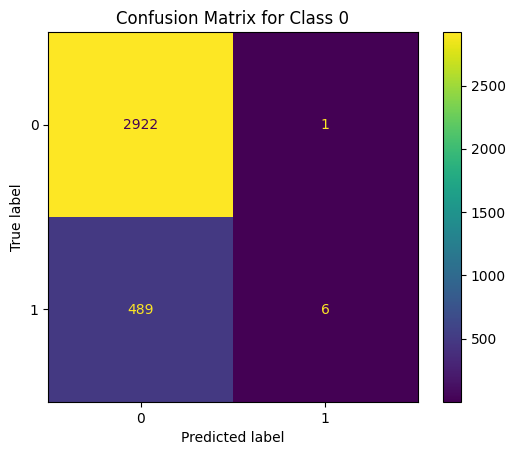

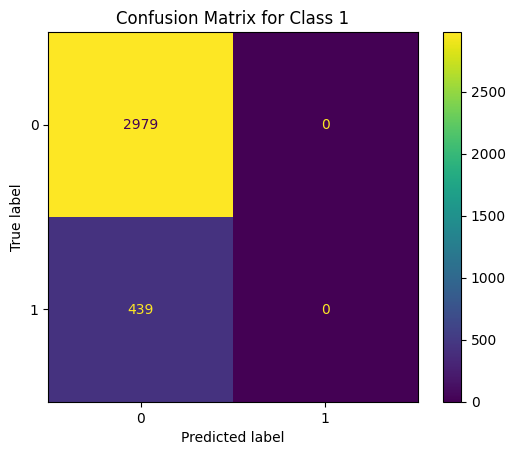

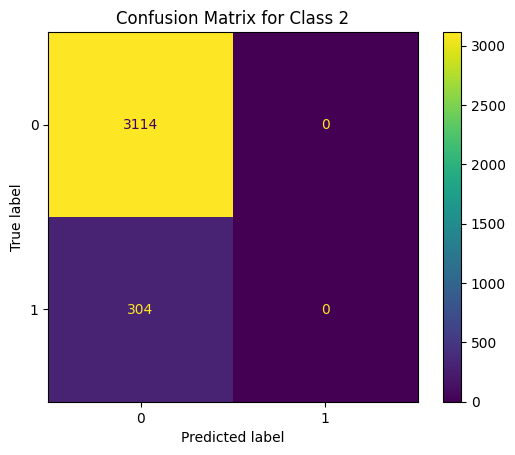

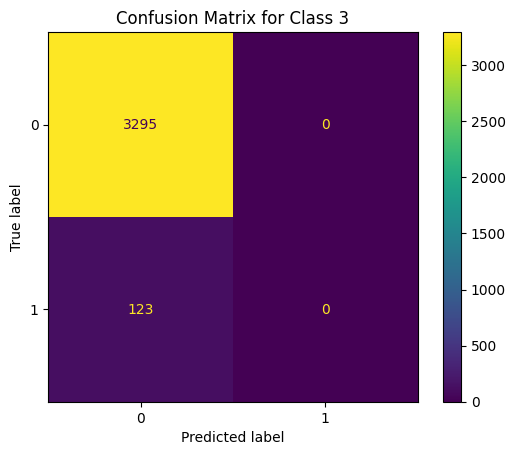

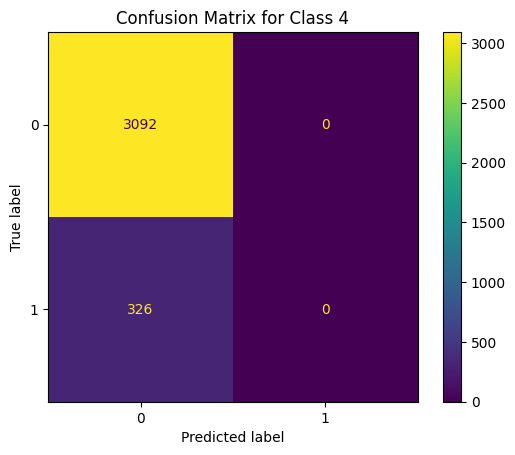

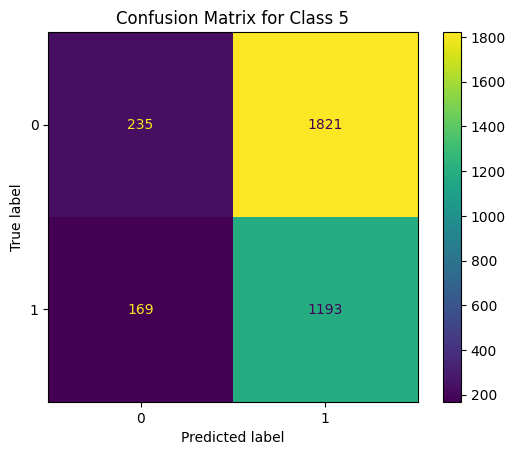

In [84]:
# Calculate the confusion matrix and ROC curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming predictions is of shape (num_samples, num_classes)
# Also assuming true_labels is of the same shape

# For each class
for i in range(y_data.shape[1]):  # y_data.shape[1] is the number of classes
    # Convert predicted probabilities to binary (0 or 1)
    pred_labels_binary = (predictions[:, i] > 0.5).astype(int)

    # Convert true labels to binary using the same threshold
    true_labels_binary = (true_labels[:, i] > 0.5).astype(int)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels_binary, pred_labels_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    disp.plot()
    plt.title(f'Confusion Matrix for Class {i}')
    plt.show()

In [85]:
from sklearn.metrics import accuracy_score

# Assuming predictions is of shape (num_samples, num_classes)
# And true_labels is also of shape (num_samples, num_classes)

# Convert predicted probabilities to binary (0 or 1)
pred_labels_binary = (predictions > 0.5).astype(int)

# Convert true labels to binary format
true_labels_binary = (true_labels > 0.5).astype(int)

# Calculate accuracy for each class
accuracy_per_class = []
for i in range(true_labels.shape[1]):  # Iterate over each class
    accuracy = accuracy_score(true_labels_binary[:, i], pred_labels_binary[:, i])
    accuracy_per_class.append(accuracy)

# Overall accuracy for multi-label classification (subset accuracy)
overall_accuracy = (true_labels_binary == pred_labels_binary).mean()

print("Accuracy per class:", accuracy_per_class)
print("Overall accuracy (subset accuracy):", overall_accuracy)


Accuracy per class: [0.8566413107080164, 0.8715623171445289, 0.9110590988882388, 0.9640140433001756, 0.9046225863077824, 0.41778818022235226]
Overall accuracy (subset accuracy): 0.820947922761849


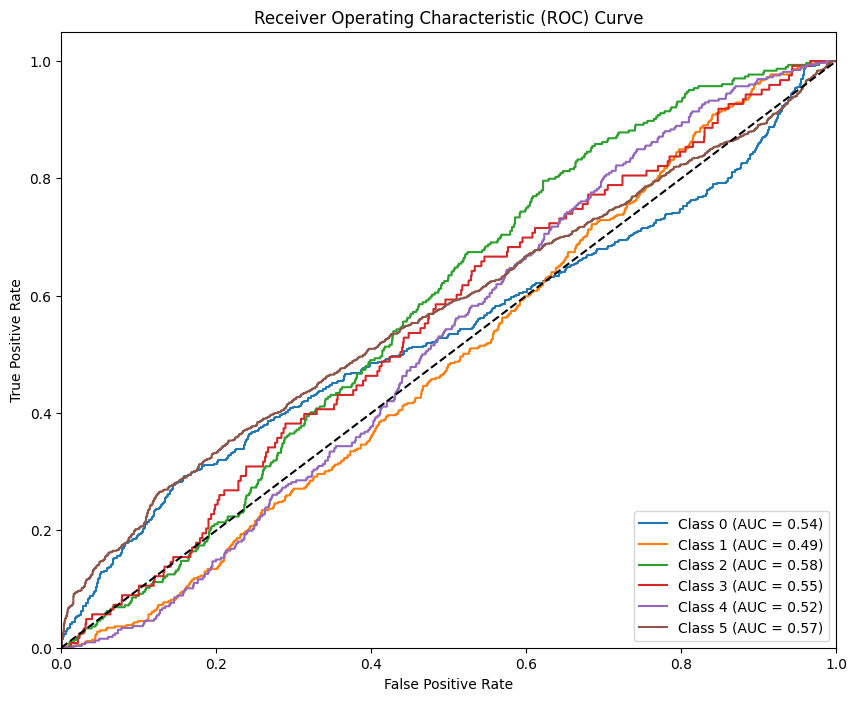

In [86]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for i in range(y_data.shape[1]):  # Loop over each class
    # Convert true labels to binary using a threshold of 0.5
    true_binary = (true_labels[:, i] > 0.5).astype(int)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(true_binary, predictions[:, i])  
    roc_auc = auc(fpr, tpr)  

    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')  # Plot ROC curve

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [87]:
columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
results_df = pd.DataFrame(predictions, columns=columns)

# 打印 DataFrame
print(results_df)

      seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
0         0.091756  0.146085  0.061771   0.068932   0.100484    0.496047
1         0.105514  0.143066  0.051546   0.062910   0.088193    0.515333
2         0.104785  0.142184  0.051160   0.062531   0.086347    0.518169
3         0.100937  0.140539  0.053150   0.062416   0.082346    0.527271
4         0.108396  0.141678  0.049490   0.061613   0.085334    0.521184
...            ...       ...       ...        ...        ...         ...
3413      0.103662  0.142637  0.051569   0.063016   0.087157    0.516524
3414      0.106934  0.141831  0.050252   0.061854   0.085792    0.520026
3415      0.107357  0.142063  0.048628   0.062282   0.086165    0.521915
3416      0.106815  0.142290  0.050101   0.062153   0.086200    0.519245
3417      0.104856  0.145148  0.050004   0.064905   0.093801    0.509163

[3418 rows x 6 columns]


In [88]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
test_data = pd.read_csv(PATH + 'test.csv')
#test_data = pd.read_csv("test.csv")
sub = pd.DataFrame({'eeg_id':test_data.eeg_id.values})
sub[TARGETS] = results_df
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.091756,0.146085,0.061771,0.068932,0.100484,0.496047


In [90]:
!pip install captum

  Obtaining dependency information for captum from https://files.pythonhosted.org/packages/7d/2d/57138b29a53d1fd267c8093989f6ec64ef55d3c6bd336fac475239c61b97/captum-0.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.2 MB/s eta 0:00:00:00:01


In [91]:
import captum

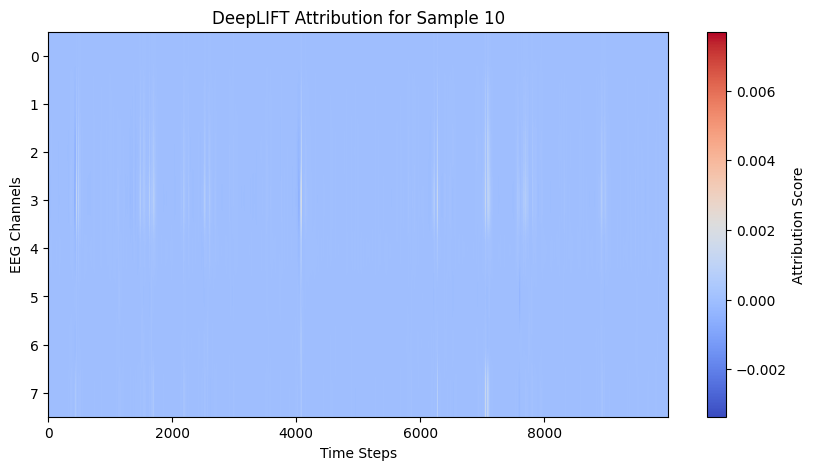

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from captum.attr import DeepLift
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model and data loaders are defined
model.eval()  # Ensure the model is in evaluation mode

def explain_with_deeplift(model, data_loader, device):
    model.train()  # Switch to training mode to enable gradients
    deeplift = DeepLift(model)
    attributions_list = []
    
    for inputs, _ in data_loader:
        inputs = inputs.to(device)
        baseline = torch.zeros_like(inputs).to(device)  # Baseline (zero tensor)
        
        attributions = deeplift.attribute(inputs, baseline, target=0)  # Target class index
        attributions_list.append(attributions.cpu().detach().numpy())
    
    model.eval()  # Switch back to evaluation mode
    return np.concatenate(attributions_list, axis=0)


# Compute attributions
attributions = explain_with_deeplift(model, val_loader, device)

# Visualize attributions for a sample
sample_idx = 10  # Select a sample to visualize
plt.figure(figsize=(10, 5))
plt.imshow(attributions[sample_idx], aspect='auto', cmap='coolwarm')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('EEG Channels')
plt.title(f'DeepLIFT Attribution for Sample {sample_idx}')
plt.show()


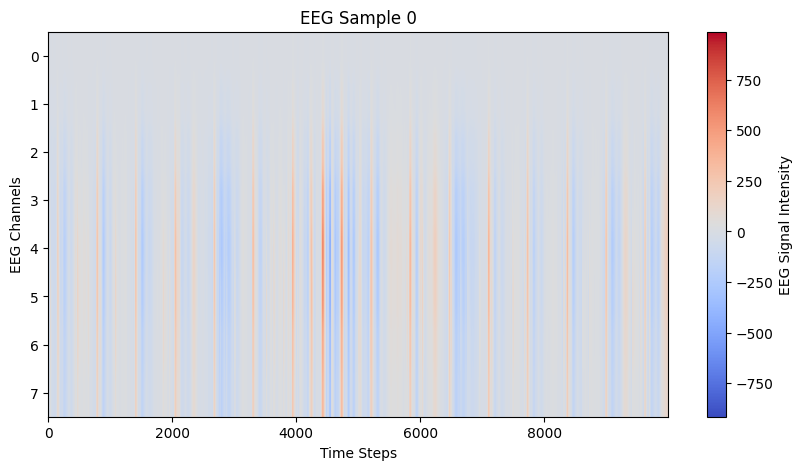

In [96]:
import matplotlib.pyplot as plt

# Get a single batch from the dataloader
sample_inputs, _ = next(iter(val_loader))

# Select one sample (assuming shape: [batch, channels, time])
sample_idx = 0  # Change this to visualize different samples
sample_eeg = sample_inputs[sample_idx].cpu().numpy()

# Plot EEG data as an image
plt.figure(figsize=(10, 5))
plt.imshow(sample_eeg, aspect='auto', cmap='coolwarm')
plt.colorbar(label='EEG Signal Intensity')
plt.xlabel('Time Steps')
plt.ylabel('EEG Channels')
plt.title(f'EEG Sample {sample_idx}')
plt.show()


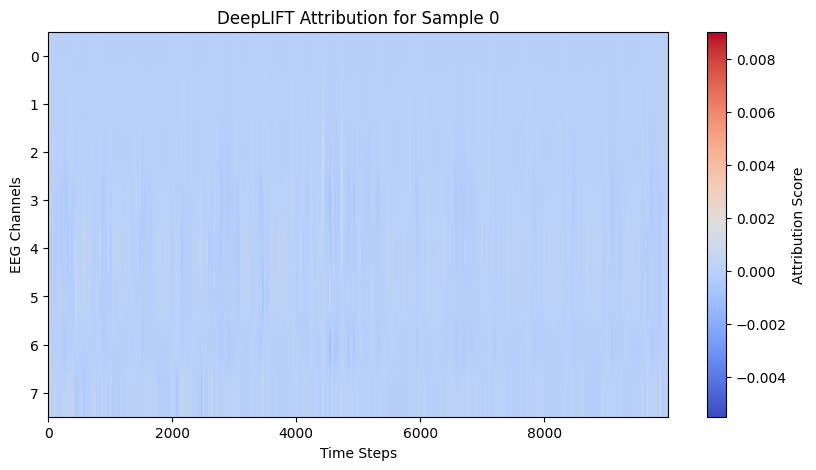

In [97]:
# Visualize attributions for a sample
sample_idx = 0  # Change to visualize another sample
plt.figure(figsize=(10, 5))
plt.imshow(attributions[sample_idx], aspect='auto', cmap='coolwarm')
plt.colorbar(label='Attribution Score')
plt.xlabel('Time Steps')
plt.ylabel('EEG Channels')
plt.title(f'DeepLIFT Attribution for Sample {sample_idx}')
plt.show()
